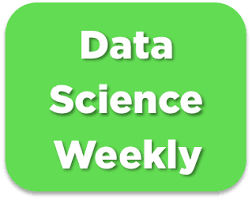

# **Challenge : predict conversions** 🏆🏆

# Import libraries

In [ ]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.metrics import classification_report, accuracy_score,recall_score,precision_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.compose import ColumnTransformer


import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
import seaborn as sns

from IPython.display import display
plt.style.use('ggplot')

# Read file with labels

In [ ]:
data = pd.read_csv('/content/conversion_data_train.csv')
print('Set with labels (our train+test) :', data.shape)

Set with labels (our train+test) : (284580, 6)


In [ ]:
data.head()

,country,age,new_user,source,total_pages_visited,converted
0,China,22,1,Direct,2,0
1,UK,21,1,Ads,3,0
2,Germany,20,0,Seo,14,1
3,US,23,1,Seo,3,0
4,US,28,1,Direct,3,0


# **Explore dataset**

#**Part 1 :  EDA**

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284580 entries, 0 to 284579
Data columns (total 6 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   country              284580 non-null  object
 1   age                  284580 non-null  int64 
 2   new_user             284580 non-null  int64 
 3   source               284580 non-null  object
 4   total_pages_visited  284580 non-null  int64 
 5   converted            284580 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 13.0+ MB


In [ ]:
data.describe(include='all')

,country,age,new_user,source,total_pages_visited,converted
count,284580,284580.000000,284580.000000,284580,284580.000000,284580.000000
unique,4,NaN,NaN,3,NaN,NaN
top,US,NaN,NaN,Seo,NaN,NaN
freq,160124,NaN,NaN,139477,NaN,NaN
mean,NaN,30.564203,0.685452,NaN,4.873252,0.032258
std,NaN,8.266789,0.464336,NaN,3.341995,0.176685
min,NaN,17.000000,0.000000,NaN,1.000000,0.000000
25%,NaN,24.000000,0.000000,NaN,2.000000,0.000000
50%,NaN,30.000000,1.000000,NaN,4.000000,0.000000
75%,NaN,36.000000,1.000000,NaN,7.000000,0.000000


In [ ]:
# View missing values
data.isnull().sum() / len(data) * 100

,0
country,0.0
age,0.0
new_user,0.0
source,0.0
total_pages_visited,0.0
converted,0.0


In [ ]:
data = data.drop(data[data['converted'] == 59202].index)

In [ ]:
# View Duplicates
print(f"Percentage of duplicated rows is {(data.duplicated().sum() /  len (data) * 100).round(2)}%")

Percentage of duplicated rows is 94.44%


##Data Distribution

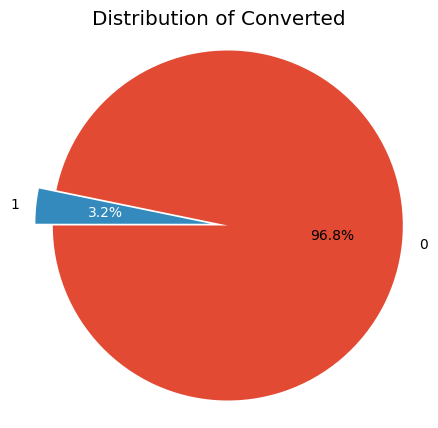

In [ ]:
# Target distribution
converted_counts = data['converted'].value_counts()

plt.figure(figsize=(5, 5), facecolor = "white")
patches, texts, autotexts  = plt.pie(
    converted_counts, labels=converted_counts.index,
    autopct='%1.1f%%', startangle=180,
    explode=(0.1, 0))
autotexts[1].set_color('white')
plt.title('Distribution of Converted')
plt.axis('equal')
plt.show()


- The pie chart above indicates that the target disribution is unbalanced.
- We have no missing values and there are 83.73 % duplicate rows. There are 284580 rows and  6  columns in the dataset.
- We seem to have outliers in 'age' this will be handled later on.




##Categorical distribution

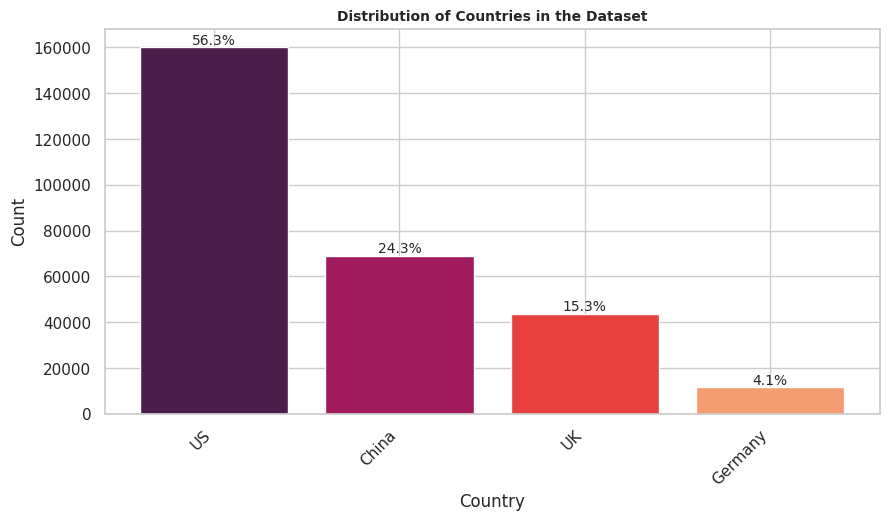

In [ ]:
# Country Distribution
country_counts = data['country'].value_counts()
fig, ax = plt.subplots(figsize=(10, 5))
bars = ax.bar(country_counts.index, country_counts.values, color=sns.color_palette('rocket', len(country_counts)))
ax.bar_label(bars, labels=[f"{(count / len(data)) * 100:.1f}%" for count in country_counts.values], fontsize=10)

plt.xticks(rotation=45, ha='right')
plt.title('Distribution of Countries in the Dataset', fontsize=10, fontweight='bold')
plt.xlabel('Country', fontsize=12)
plt.ylabel('Count', fontsize=12)

plt.show()

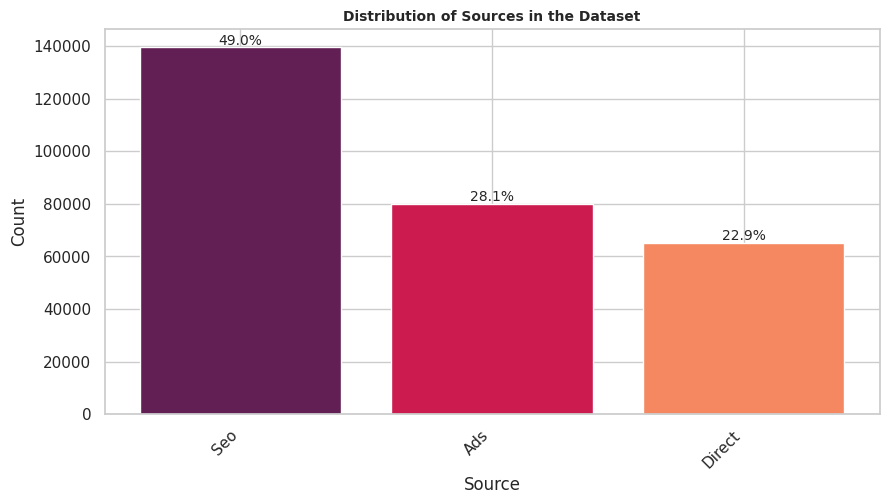

In [ ]:
# Source Distribution

source_counts = data['source'].value_counts()
fig, ax = plt.subplots(figsize=(10, 5))
bars = ax.bar(source_counts.index, source_counts.values, color=sns.color_palette('rocket', len(source_counts)))
ax.bar_label(bars, labels=[f"{(count / len(data)) * 100:.1f}%" for count in source_counts.values], fontsize=10)

plt.xticks(rotation=45, ha='right')
plt.title('Distribution of Sources in the Dataset', fontsize=10, fontweight='bold')
plt.xlabel('Source', fontsize=12)
plt.ylabel('Count', fontsize=12)

# Show plot
plt.show()

##Numerical distribution

In [ ]:
# Total_pages_visited Distribution
total_pages = data['total_pages_visited'].value_counts().reset_index()
total_pages.columns = ['Total Pages Visited', 'Count']

fig = px.bar(total_pages,
             x='Total Pages Visited',
             y='Count',
             color='Count',
             color_continuous_scale='greens',
             title='Distribution of Total Pages Visited in the Dataset')

fig.update_layout(xaxis_title='Total Pages Visited',
                  yaxis_title='Count',
                  xaxis_tickangle=-45)

fig.show(renderer='colab')

In [ ]:
# Age distribution
ages = data['age'].value_counts().reset_index()
ages.columns = ['age', 'Count']

fig = px.bar(ages,
             x='age',
             y='Count',
             color='Count',
             color_continuous_scale='greens',
             title='Distribution of Ages in the Dataset')

fig.update_layout(xaxis_title='Ages',
                  yaxis_title='Count',
                  xaxis_tickangle=-45)

fig.show(renderer='colab')

##Outliers

In [ ]:
# Find Q1, Q3 and IQR
Q1 = data['age'].quantile(0.25)
Q3 = data['age'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
outliers = (data['age'] < Q1 - 1.5 * IQR) | (data['age'] > Q3 + 1.5 *IQR)

In [ ]:
# Remove outliers
cleaned_data = data[~outliers]
print('Data shape:', cleaned_data.shape)

Data shape: (283211, 6)


In [ ]:
fig = px.box(cleaned_data.melt(value_vars='age',
                                     var_name='Feature',
                                     value_name='Value'),
             y='Value',
             color='Feature',
             facet_col='Feature',
             title='Age')

fig.update_layout(height=400, width=400, showlegend=False)
fig.show(renderer='colab')

##Correlation Analysis

In [ ]:
corr_matrix= cleaned_data.corr(numeric_only=True)

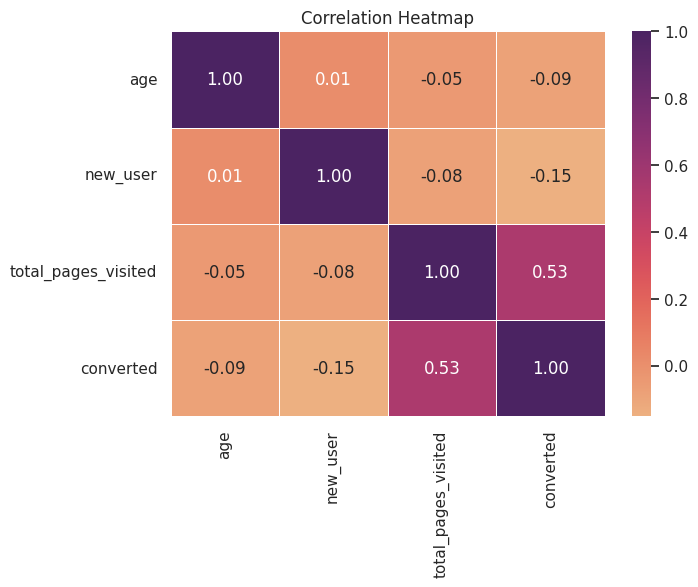

In [ ]:
#Correlation Heatmap
plt.figure(figsize=(7, 5))
sns.heatmap(corr_matrix, annot=True, cmap="flare", fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap")
plt.show()

<Figure size 600x500 with 0 Axes>

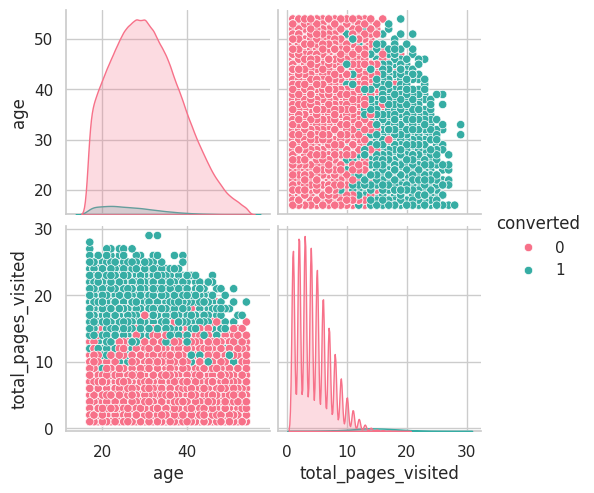

In [ ]:
plt.figure(figsize=(6, 5))
sns.pairplot(cleaned_data, hue="converted", vars=['age', 'total_pages_visited'],palette="husl")
plt.show()

- There are no correlation between numerial features.
- There is a strong correlation between the total_pages_visited and the target.

In [ ]:
#Save cleaned data
cleaned_data.to_csv('/content/cleaned_data.csv', index=False)

#**Machine Learning**

##Create Univariate Baseline Model

**From the EDA, we know that the most useful feature is total_pages_visited. Let's create a baseline model by using at first only this feature : in the next cells, we'll make preprocessings and train a simple (univariate) logistic regression.**

In [ ]:
dataset = cleaned_data.copy(deep=True)

In [ ]:
features_list = ['total_pages_visited']
numeric_indices = [0]
categorical_indices = []
target_variable = 'converted'

In [ ]:
X = dataset.loc[:, features_list]
Y = dataset.loc[:, target_variable]

print('Explanatory variables : ', X.columns)
print()

Explanatory variables :  Index(['total_pages_visited'], dtype='object')



In [ ]:
# Divide dataset Train set & Test set
print("Dividing into train and test sets...")
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
print("...Done.")
print()

Dividing into train and test sets...
...Done.



## Training pipeline

In [ ]:
# Preprocessing
print("Encoding categorical features and standardizing numerical features...")

featureencoder = StandardScaler()
X_train = featureencoder.fit_transform(X_train)
print("...Done")
print(X_train[0:5,:])

Encoding categorical features and standardizing numerical features...
...Done
[[ 0.03747777]
 [ 1.23418882]
 [-1.15923328]
 [ 0.33665553]
 [ 0.33665553]]


In [ ]:
# Train model
print("Train model...")
classifier = LogisticRegression()
classifier.fit(X_train, y_train)
print("...Done.")

Train model...
...Done.


In [ ]:
# Predictions on training set
print("Predictions on training set...")
Y_train_pred = classifier.predict(X_train)
print("...Done.")
print(Y_train_pred)
print()

Predictions on training set...
...Done.
[0 0 0 ... 0 0 0]



## Test pipeline

In [ ]:
# Use X_test, and the same preprocessings as in training pipeline,
# but call "transform()" instead of "fit_transform" methods (see example below)

print("Encoding categorical features and standardizing numerical features...")

X_test = featureencoder.transform(X_test)
print("...Done")
print(X_test[0:5,:])

Encoding categorical features and standardizing numerical features...
...Done
[[ 1.23418882]
 [ 0.03747777]
 [ 0.33665553]
 [-0.86005552]
 [ 2.13172211]]


In [ ]:
# Predictions on test set
print("Predictions on test set...")
Y_test_pred = classifier.predict(X_test)
print("...Done.")
print(Y_test_pred)
print()

Predictions on test set...
...Done.
[0 0 0 ... 0 0 0]



## Performance assessment

In [ ]:
# WARNING : Use the same score as the one that will be used by Kaggle !
# Here, the f1-score will be used to assess the performances on the leaderboard
print("f1-score on train set : ", f1_score(y_train, Y_train_pred))
print("f1-score on test set : ", f1_score(y_test, Y_test_pred))
print("Classification Report Test:\n", classification_report(y_test, Y_test_pred))

f1-score on train set :  0.6935687263556116
f1-score on test set :  0.7033792240300375
Classification Report Test:
               precision    recall  f1-score   support

           0       0.99      1.00      0.99     54811
           1       0.82      0.61      0.70      1832

    accuracy                           0.98     56643
   macro avg       0.91      0.80      0.85     56643
weighted avg       0.98      0.98      0.98     56643



In [ ]:
# Check performance metrics to better understand the model
print("Confusion matrix on train set : ")
print(confusion_matrix(y_train, Y_train_pred))
print()
print("Confusion matrix on test set : ")
print(confusion_matrix(y_test, Y_test_pred))
print()

Confusion matrix on train set : 
[[218280    950]
 [  2938   4400]]

Confusion matrix on test set : 
[[54571   240]
 [  708  1124]]



##Confusion Matrices

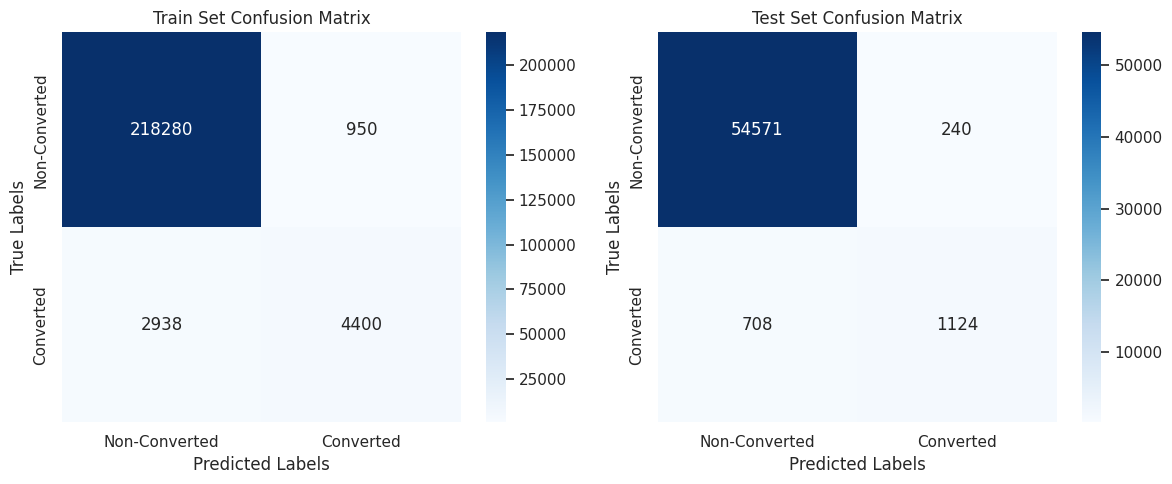

In [ ]:
# Compute confusion matrices
cm_train = confusion_matrix(y_train, Y_train_pred)
cm_test = confusion_matrix(y_test, Y_test_pred)

# Subplots and plot confusion matrices
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
for cm, axis, title in zip([cm_train, cm_test], ax, ["Train Set", "Test Set"]):
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Non-Converted", "Converted"],
                yticklabels=["Non-Converted", "Converted"], ax=axis)
    axis.set_title(f"{title} Confusion Matrix")
    axis.set_xlabel("Predicted Labels")
    axis.set_ylabel("True Labels")

plt.tight_layout()
plt.show()

**Our baseline model reaches a f1-score of almost 70%. Now, let's train another model and add more features and try to beat this score ! 🚀🚀**

#**Part 2 : Improve model's f1-score**

### **Train best classifier on all data and use it to make predictions on X_without_labels**
Before making predictions on the file conversion_data_test.csv, let's train our model on ALL the data that was in conversion_data_train.csv. Sometimes, this allows to make tiny improvements in the score because we're using more examples to train the model.

##Preprocessing

In [ ]:
data = pd.read_csv('/content/cleaned_data.csv')

In [ ]:
print("Separate target from features...\n")
target_variable = 'converted'

x = data.drop(target_variable, axis=1)
y = data.loc[:, target_variable]

print(x.info())

Separate target from features...

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 283211 entries, 0 to 283210
Data columns (total 5 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   country              283211 non-null  object
 1   age                  283211 non-null  int64 
 2   new_user             283211 non-null  int64 
 3   source               283211 non-null  object
 4   total_pages_visited  283211 non-null  int64 
dtypes: int64(3), object(2)
memory usage: 10.8+ MB
None


In [ ]:
# Automatically detect numeric and categorical columns

numeric_features = x[['age', 'new_user', 'total_pages_visited']]
categorical_features = x[['country', 'source']]

print(" Found numeric features:", numeric_features)
print("Found categorical features:", categorical_features)

 Found numeric features:         age  new_user  total_pages_visited
0        22         1                    2
1        21         1                    3
2        20         0                   14
3        23         1                    3
4        28         1                    3
...     ...       ...                  ...
283206   36         1                    1
283207   31         1                    2
283208   41         1                    5
283209   31         1                    4
283210   26         0                    3

[283211 rows x 3 columns]
Found categorical features:         country  source
0         China  Direct
1            UK     Ads
2       Germany     Seo
3            US     Seo
4            US  Direct
...         ...     ...
283206       US     Ads
283207       US     Seo
283208       US     Seo
283209       US  Direct
283210       US     Ads

[283211 rows x 2 columns]


In [ ]:
print('Divide dataset into train and test sets..')
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42,stratify =y)

Divide dataset into train and test sets..


##**Pipeline**

In [ ]:
# Define the list of numeric and categorical features
numeric_features = ['age', 'new_user', 'total_pages_visited']
categorical_features = ['country', 'source']

# Define preprocessing for numeric features
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

# Define preprocessing for categorical features
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder())
])

# Define the preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

In [ ]:
# Apply preprocessing to the train and test sets
print("Preprocessing train set...")
X_train = preprocessor.fit_transform(X_train)
print("Preprocessing test set...")
X_test = preprocessor.transform(X_test)

Preprocessing train set...
Preprocessing test set...


##1. **Feature Engineering : Logistic Regression Model**

##Training

In [ ]:
# Train model
logreg_clf = LogisticRegression(max_iter=1000)

print("Train model...")
logreg_clf = LogisticRegression()
logreg_clf.fit(X_train, y_train)
print("...Done.")

Train model...
...Done.


In [ ]:
# Predictions on training set
print("Predictions on training set...")
Y_train_pred_logreg = logreg_clf.predict(X_train)
print("...Done.")
print(Y_train_pred_logreg)
print()

Predictions on training set...
...Done.
[0 0 0 ... 0 0 0]



##Testing

In [ ]:
print("Predictions on Test set...")
Y_test_pred_logreg = logreg_clf.predict(X_test)
print("...Done.")
print(Y_test_pred_logreg)

Predictions on Test set...
...Done.
[0 0 1 ... 0 0 0]


##Performance

In [ ]:
print("f1-score on test set : ", f1_score(y_test, Y_test_pred_logreg))
print("Classification Report:\n", classification_report(y_test, Y_test_pred_logreg))

f1-score on test set :  0.7694610778443114
Classification Report:
               precision    recall  f1-score   support

           0       0.99      1.00      0.99     54809
           1       0.85      0.70      0.77      1834

    accuracy                           0.99     56643
   macro avg       0.92      0.85      0.88     56643
weighted avg       0.99      0.99      0.99     56643



##Confusion Matrices of train and test sets

In [ ]:
# Check performance metrics to better understand the model
print("Confusion matrix on train set : ")
print(confusion_matrix(y_train, Y_train_pred_logreg))
print()
print("Confusion matrix on test set : ")
print(confusion_matrix(y_test, Y_test_pred_logreg))
print()

Confusion matrix on train set : 
[[218378    854]
 [  2293   5043]]

Confusion matrix on test set : 
[[54588   221]
 [  549  1285]]



##**2. Optimization with GridSearch and class_weight**

##Training optimized model

In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'C': [70, 80, 90, 120, 200, 300],  # Regularization strength
    'penalty': ['l1','l2'], # L1 = Lasso (sparse), L2 = Ridge (default)
    'class_weight':[{0: 28 , 1: 38}],
    'solver': ['liblinear'],
}

# Grid Search with 5-fold Cross Validation
gridsearch = GridSearchCV(logreg_clf, param_grid, cv=5)
gridsearch.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=LogisticRegression(),
             param_grid={'C': [70, 80, 90, 120, 200, 300],
                         'class_weight': [{0: 28, 1: 38}],
                         'penalty': ['l1', 'l2'], 'solver': ['liblinear']})

In [ ]:
print("Predictions on training set...")
Y_train_pred_gs = gridsearch.predict(X_train)
print("...Done.")
print(Y_train_pred_gs)
print()

Predictions on training set...
...Done.
[0 0 0 ... 0 0 0]



##Testing GridSearch

In [ ]:
# Predictions on training set
print("Predictions on training set...")
Y_test_pred_gs =gridsearch.predict(X_test)
print("...Done.")
print(Y_train_pred_gs)

Predictions on training set...
...Done.
[0 0 0 ... 0 0 0]


##Performance

In [ ]:
from sklearn.metrics import classification_report, accuracy_score

print("f1-score on test set : ", f1_score(y_test, Y_test_pred_gs))
print("Classification Report:\n", classification_report(y_test, Y_test_pred_gs))

f1-score on test set :  0.7769495412844036
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.99      0.99     54809
           1       0.82      0.74      0.78      1834

    accuracy                           0.99     56643
   macro avg       0.91      0.87      0.88     56643
weighted avg       0.99      0.99      0.99     56643



##Confusion matrices of Optimized LogReg Model with GridSearch

In [ ]:
# Check performance metrics to better understand the model
print("Confusion matrix on train set : ")
print(confusion_matrix(y_train, Y_train_pred_gs))
print()
print("Confusion matrix on test set : ")
print(confusion_matrix(y_test, Y_test_pred_gs))
print()

Confusion matrix on train set : 
[[218064   1168]
 [  2034   5302]]

Confusion matrix on test set : 
[[54510   299]
 [  479  1355]]



#**3. XGBoost Model**

In [ ]:
import xgboost as xgb
model_xgb = xgb.XGBClassifier()

##Train Model

In [ ]:
# Train model
model_xgb.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [ ]:
# Predictions on training set
print("Predictions on training set...")
Y_train_pred_xgb = model_xgb.predict(X_train)

Predictions on training set...


##Testing

In [ ]:
# Predictions on training set
print("Predictions on training set...")
Y_test_pred_xgb =model_xgb.predict(X_test)
print("...Done.")
print(Y_test_pred_xgb)
print()

Predictions on training set...
...Done.
[0 0 1 ... 0 0 0]



##Model Evaluation

In [ ]:
# Evaluate the model
print("XGBoost Model Accuracy:", accuracy_score(y_test, Y_test_pred_xgb))
print("Classification Report:\n", classification_report(y_test, Y_test_pred_xgb))

XGBoost Model Accuracy: 0.9859294175802835
Classification Report:
               precision    recall  f1-score   support

           0       0.99      1.00      0.99     54809
           1       0.84      0.70      0.76      1834

    accuracy                           0.99     56643
   macro avg       0.91      0.85      0.88     56643
weighted avg       0.99      0.99      0.99     56643



##Confusion Matrices of XGBOOST model train and test sets

In [ ]:
# Check performance metrics to better understand the model
print("Confusion matrix on train set : ")
print(confusion_matrix(y_train, Y_train_pred_xgb))
print()
print("Confusion matrix on test set : ")
print(confusion_matrix(y_test, Y_test_pred_xgb))
print()

Confusion matrix on train set : 
[[218414    818]
 [  2170   5166]]

Confusion matrix on test set : 
[[54564   245]
 [  552  1282]]



#**4. Implementing VotingClassifier**

##Let's combine the three models and use VotingClassifier and implement a soft voting for weighted probabilities.

In [ ]:
from sklearn.ensemble import VotingClassifier

# Create Voting Classifier
voting_clf = VotingClassifier(
    estimators=[
        ('logreg', logreg_clf),
        ('gridsearch_lr', gridsearch),
        ('xgb', model_xgb)
    ],
    voting='soft'
)

##Train the ensemble model

In [ ]:
# Train the ensemble model
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('logreg', LogisticRegression()),
                             ('gridsearch_lr',
                              GridSearchCV(cv=5, estimator=LogisticRegression(),
                                           param_grid={'C': [70, 80, 90, 120,
                                                             200, 300],
                                                       'class_weight': [{0: 28,
                                                                         1: 38}],
                                                       'penalty': ['l1', 'l2'],
                                                       'solver': ['liblinear']})),
                             ('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=No...
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rate=None, max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=None,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=None, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=None, ...))],
                 voting='soft')

In [ ]:
# Predictions on training set
print("Predictions on training set...")
Y_train_pred_voting = voting_clf.predict(X_train)

Predictions on training set...


###Testing

In [ ]:
# Predictions
y_pred_voting = voting_clf.predict(X_test)

##Model Evaluation

In [ ]:
# Evaluate the model
print("VotingModel Accuracy:", accuracy_score(y_test, y_pred_voting))
print("Classification Report:\n", classification_report(y_test, y_pred_voting))

VotingModel Accuracy: 0.9863001606553325
Classification Report:
               precision    recall  f1-score   support

           0       0.99      1.00      0.99     54809
           1       0.84      0.71      0.77      1834

    accuracy                           0.99     56643
   macro avg       0.91      0.86      0.88     56643
weighted avg       0.99      0.99      0.99     56643



##Confusion matrices of VotingClassifier model's train and test sets

In [ ]:
# Check performance metrics to better understand the model
print("Confusion matrix on train set : ")
print(confusion_matrix(y_train, Y_train_pred_voting))
print()
print("Confusion matrix on test set : ")
print(confusion_matrix(y_test, y_pred_voting))
print()

Confusion matrix on train set : 
[[218302    930]
 [  2150   5186]]

Confusion matrix on test set : 
[[54556   253]
 [  523  1311]]



##**Model perfomance comparaison**

In [ ]:
# Define models and their predictions
models = {
    "LogReg Feature Engineering": Y_test_pred_logreg,
    "LogReg GridSearch & class_weight": Y_test_pred_gs,
    "XGBoost Model": Y_test_pred_xgb,
    "VotingClassifier": y_pred_voting
}

# Initialize results list
results = []

# Compute metrics for each model dynamically
for model_name, y_pred in models.items():
    results.append({
        "Model": model_name,
        "Accuracy": accuracy_score(y_test, y_pred),
        "F1 Score": f1_score(y_test, y_pred),
        "Recall": recall_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred)
    })

# Convert results to DataFrame
performance_df = pd.DataFrame(results)

# Print results
print(performance_df)


                              Model  Accuracy  F1 Score    Recall  Precision
0        LogReg Feature Engineering  0.986406  0.769461  0.700654   0.853254
1  LogReg GridSearch & class_weight  0.986265  0.776950  0.738822   0.819226
2                     XGBoost Model  0.985929  0.762868  0.699019   0.839555
3                  VotingClassifier  0.986300  0.771630  0.714831   0.838235


##**Visualization**

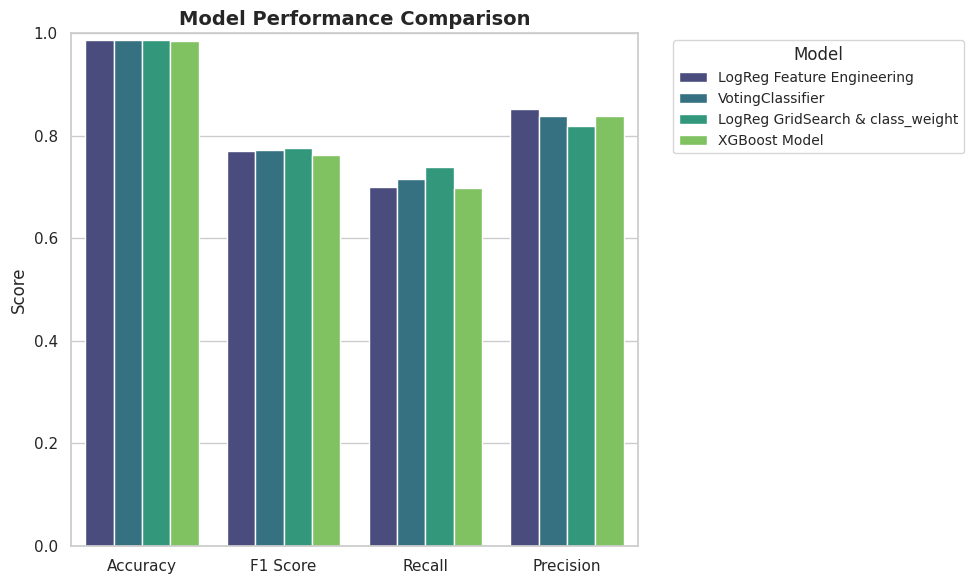

In [ ]:
# Convert results to a DataFrame
performance_df = pd.DataFrame(results)

# Sort by Accuracy
performance_df = performance_df.sort_values(by="Accuracy", ascending=False)

# Melt the DataFrame for Seaborn (long format for grouped bar plot)
df_melted = performance_df.melt(id_vars="Model", var_name="Metric", value_name="Score")

# Custom color palette
custom_palette = {
    "Accuracy": "royalblue",
    "F1 Score": "seagreen",
    "Recall": "darkorange",
    "Precision": "crimson"
}

# Plot using Seaborn
plt.figure(figsize=(10, 6))
sns.barplot(x="Metric", y="Score", hue="Model", data=df_melted, palette="viridis")

# Formatting
plt.title("Model Performance Comparison", fontsize=14, fontweight='bold')
plt.ylabel("Score", fontsize=12)
plt.xlabel("")
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
plt.legend(title="Model", bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)

# Ensure the y-axis goes from 0 to 1
plt.ylim(0, 1)

plt.tight_layout()
plt.show()

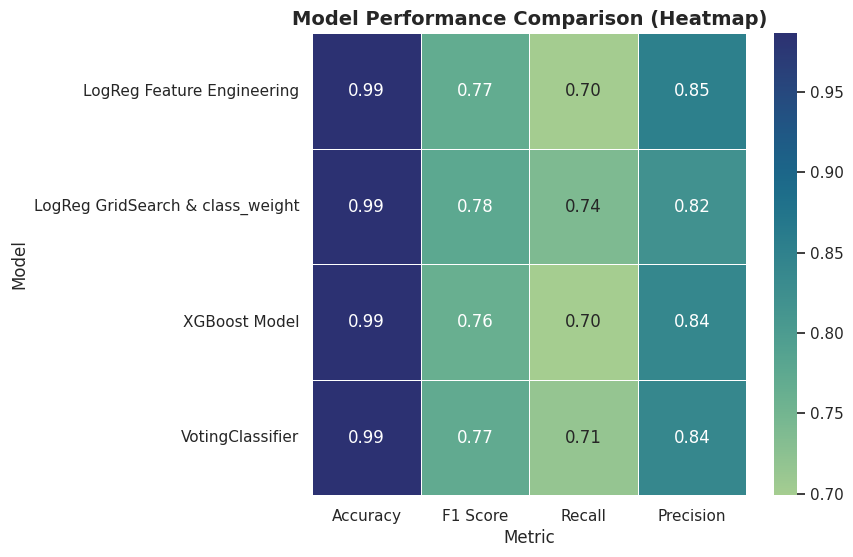

In [ ]:
# Convert results to a DataFrame
performance_df = pd.DataFrame(results)

# Set model names as the index
performance_df.set_index("Model", inplace=True)

# Create the heatmap
plt.figure(figsize=(7, 6))
sns.heatmap(performance_df, annot=True, cmap="crest", linewidths=0.5, fmt=".2f")

# Formatting
plt.title("Model Performance Comparison (Heatmap)", fontsize=14, fontweight="bold")
plt.xlabel("Metric", fontsize=12)
plt.ylabel("Model", fontsize=12)

# Show plot
plt.show()

##**Model Showdown: Which One Wins?**

1. LogReg GridSearch & Class Weight (98.63% Accuracy) → Best F1-Score (77.69%) & Recall (73.88%), meaning it catches the most positives while keeping balance.

2. LogReg Feature Engineering (98.64% Accuracy) → Highest Precision (85.33%), so it avoids false alarms, but Recall (70.07%) is a bit lower.

3.  VotingClassifier (98.63% Accuracy) → Solid across all metrics, with good Recall (71.48%) and F1-Score (77.16%), but slightly lower Precision (83.82%).

4. XGBoost (98.59% Accuracy) → High Precision (83.96%), but the lowest Recall (69.90%), meaning it plays it safe but may miss some positives.

**Final Verdict: Which one to pick?**

- Need to catch all positives? → GridSearch & Class Weight 🏆
- Hate false positives? → Feature Engineering 🎯
- Want an all-rounder? → VotingClassifier ⚖️
- Prefer conservative predictions? → XGBoost 🤖

🔥 Winner for Most Balanced Performance? → **GridSearch & Class Weight!** 🏆🚀

#**Part 3: Predictions with the file data_test.csv**

In [ ]:
# Read data without labels
data_without_labels = pd.read_csv('/content/conversion_data_test.csv')
print('Prediction set (without labels) :', data_without_labels.shape)

features_list = ['country', 'age', 'new_user', 'source', 'total_pages_visited']
X_without_labels = data_without_labels.loc[:, features_list]

Prediction set (without labels) : (31620, 5)


In [ ]:
data_without_labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31620 entries, 0 to 31619
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   country              31620 non-null  object
 1   age                  31620 non-null  int64 
 2   new_user             31620 non-null  int64 
 3   source               31620 non-null  object
 4   total_pages_visited  31620 non-null  int64 
dtypes: int64(3), object(2)
memory usage: 1.2+ MB


In [ ]:
# Preprocessings on train set
print("Performing preprocessings on train set...")
print(X_without_labels.head())
X_without_labels = preprocessor.fit_transform(X_without_labels)
print("...Done.")

Performing preprocessings on train set...
  country  age  new_user  source  total_pages_visited
0      UK   28         0     Seo                   16
1      UK   22         1  Direct                    5
2   China   32         1     Seo                    1
3      US   32         1     Ads                    6
4   China   25         0     Seo                    3
...Done.


In [ ]:
# Make predictions and dump to file
# WARNING : MAKE SURE THE FILE IS A CSV WITH ONE COLUMN NAMED 'converted' AND NO INDEX !
# WARNING : FILE NAME MUST HAVE FORMAT 'conversion_data_test_predictions_[name].csv'
# where [name] is the name of your team/model separated by a '-'
# For example : [name] = AURELIE-model1
data = {'converted': gridsearch.predict(X_without_labels)}

Y_predictions = pd.DataFrame(columns=['converted'],data=data)
Y_predictions.to_csv('/content/conversion_data_test_predictions_ronalyn-logreg-v2.csv', index=False)


#**Part 4 : Analyze best model's parameters**

Since LogReg GridSearch & Class Weight is our best model, let's analyze its parameters:

In [ ]:
# Print the best parameters found by GridSearchCV
print(gridsearch.best_params_)

{'C': 70, 'class_weight': {0: 28, 1: 38}, 'penalty': 'l1', 'solver': 'liblinear'}


###**Model’s Coefficients (Feature Importance)**

In [ ]:
feature_names = preprocessor.get_feature_names_out()
feature_names

array(['num__age', 'num__new_user', 'num__total_pages_visited',
       'cat__country_China', 'cat__country_Germany', 'cat__country_UK',
       'cat__country_US', 'cat__source_Ads', 'cat__source_Direct',
       'cat__source_Seo'], dtype=object)

In [ ]:
# Extract feature names
feature_names = ['num__age', 'num__new_user', 'num__total_pages_visited',
       'cat__country_China', 'cat__country_Germany', 'cat__country_UK',
       'cat__country_US', 'cat__source_Ads', 'cat__source_Direct',
       'cat__source_Seo']

# Get model coefficients
coefficients = gridsearch.best_estimator_.coef_[0]

# Create DataFrame for better visualization
coef_df = pd.DataFrame({"Feature": feature_names, "Coefficient": coefficients})
coef_df["Absolute Coef"] = coef_df["Coefficient"].abs()
coef_df = coef_df.sort_values(by="Absolute Coef", ascending=False)

# Display feature importance
print(coef_df)

                    Feature  Coefficient  Absolute Coef
3        cat__country_China    -4.790852       4.790852
8        cat__source_Direct    -3.047897       3.047897
9           cat__source_Seo    -2.920778       2.920778
7           cat__source_Ads    -2.861271       2.861271
2  num__total_pages_visited     2.537546       2.537546
6           cat__country_US    -1.470491       1.470491
5           cat__country_UK    -1.141864       1.141864
4      cat__country_Germany    -0.898800       0.898800
1             num__new_user    -0.808957       0.808957
0                  num__age    -0.597319       0.597319


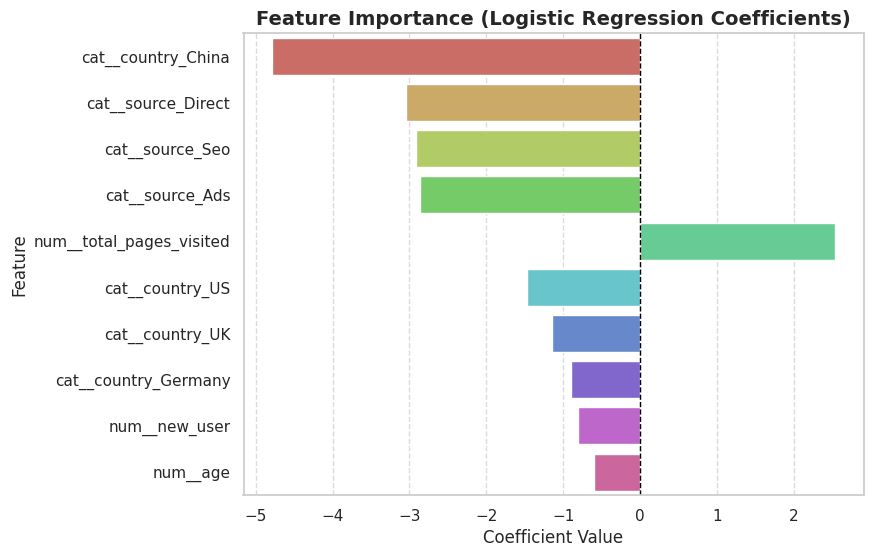

In [ ]:
# Plot feature importance
plt.figure(figsize=(8, 6))
sns.barplot(x="Coefficient", y="Feature", hue="Feature", data=coef_df, palette="hls", legend=False)
plt.axvline(x=0, color="black", linestyle="--", linewidth=1)
plt.title("Feature Importance (Logistic Regression Coefficients)", fontsize=14, fontweight="bold")
plt.xlabel("Coefficient Value", fontsize=12)
plt.ylabel("Feature", fontsize=12)
plt.grid(axis="x", linestyle="--", alpha=0.7)
plt.show()


#**Key Insights from Absolute Coefficients**

**Features:**

- cat_country_China : -4.79 - Strongly decreases conversion likelihood.
- cat_source_Direct : -3.05 - Users coming from Direct Traffic convert much less.
- cat_source_Seo : -2.92 - Ads aren't leading to conversions effectively.
- num_total_pages_visited: 2.54 - More pages visited increases conversion probability.
- cat_country_US : - 1.47 US - US visitors convert less than other countries.
- cat_country_UK : - 1.14 - UK visitors also convert less.
- cat_country_Germany: - 0.90 - German visitors have a slight negative effect on conversion.
- num_new_user : - 0.81 - New users convert less than returning users.
- num_age : - 0.60 - Older users convert slightly less.

#**Business Recommendations Based on the Model**

✅ Improve Conversion for China & US Visitors

- Localize content for these regions.
- Consider region-specific offers or promotions.

✅ Optimize Ad & SEO Campaigns: Since Ads & SEO users convert less, analyze why:
- Are ads targeting the wrong audience?
- Is SEO traffic not landing on the right pages?
- A/B test new ad messaging or landing pages.

✅ Increase Engagement for Direct Traffic Users

- Offer personalized incentives (e.g., discounts or pop-ups for direct visitors).
- Improve navigation so users engage with more pages.

✅ Encourage More Page Visits

- The only positive coefficient (total_pages_visited = +2.54) shows that users who explore more convert better.
- Design better content flow to encourage browsing.

✅ Focus on Returning Users

- New users convert less than existing ones → Retarget them!
- Use email marketing or incentives for first-time visitors.